In [1]:
# Leemos los pickles de imagenes y embedding de texto
# En caso contrario perdiamos mucho tiempo ...
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Path donde se alojan los pickles (cambiarlo segun corresponda)
path="/content/drive/My Drive/Proyecto_Deep/pickles/"

In [3]:
# Verificamos qie exisnta los pickles en el path
!ls /content/drive/'My Drive'/Proyecto_Deep/pickles/

Loading_pickles.ipynb	      VAE_model1.ipynb	x_train.pkl
Loading_pickles_v3.ipynb      x_test.pickle	y_test64.pkl
notebooks		      x_test.pkl	y_test.pkl
Prueba_Embedding_Texto.ipynb  x_train.pickle	y_train64.pkl


**Importamos librerias relevantes**

In [0]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, \
Lambda, Dropout, UpSampling2D, MaxPooling2D
from tensorflow.keras.losses import binary_crossentropy, MeanSquaredError,\
MeanAbsoluteError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.backend import reshape

In [0]:
# Carga pickles de imagenes a color (64,64,3)
# Nota: se deben procesar los datos, dado que esta en una tupla

# Datos de imagenes
y_train_pk = np.load('/content/drive/My Drive/Proyecto_Deep/pickles/y_train64.pkl', allow_pickle=True)
y_test_pk = np.load('/content/drive/My Drive/Proyecto_Deep/pickles/y_test64.pkl', allow_pickle=True)

In [8]:
y_test_pk[:,1][0].shape

(64, 64, 3)

In [0]:
# Carga pickles de encaje de texto usando gloveB50
# Nota: se deben procesar los datos, dado que esta en una tupla

x_train_pk = np.load('/content/drive/My Drive/Proyecto_Deep/pickles/x_train.pkl', allow_pickle=True)
x_test_pk = np.load('/content/drive/My Drive/Proyecto_Deep/pickles/x_test.pkl', allow_pickle=True)

In [0]:
# Transformamos las tuplas de los pickles y modificamos la estructura de los array
# que contienen para que los reconozca tensorflow
x_train = x_train_pk[:,1]
y_train = y_train_pk[:,1]

x_test = x_test_pk[:,1]
y_test = y_test_pk[:,1]


# np.concatenate consolida en un array lo que teniamos antes(como array de arrays)
a = np.concatenate(x_train, axis=0 )
x_train = a.reshape(32364,50)

c = np.concatenate(y_train, axis=0 )
y_train = c.reshape(32364,64, 64, 3)/255

b = np.concatenate(x_test, axis=0 )
x_test = b.reshape(8091,50)

#y_test = d.reshape(8091,64, 64, 3)/255
d = np.concatenate(y_test, axis=0 )
y_test = d.reshape(8091,64, 64, 3)/255


In [11]:
x_train[0]

array([ 1.54087203e+00,  1.97417001e+00, -1.08254202e+00, -2.19563000e+00,
        4.63806610e+00,  2.52093995e+00, -4.79618001e+00, -7.39626989e-01,
       -6.25710225e-01, -1.33598606e+00, -2.08017573e+00, -1.37138602e+00,
       -2.09747998e+00,  3.25139395e+00,  1.05989998e+00, -9.43800658e-02,
        8.19599070e-03,  2.22963401e+00, -2.55056000e+00, -2.64512002e+00,
        1.59457506e+00,  1.95994999e+00, -2.77385998e+00,  9.79699492e-02,
        6.20970003e-01, -1.18994300e+01, -1.40047803e+00,  3.50173234e+00,
        3.73828000e+00, -2.86829795e+00,  2.29308996e+01, -2.24512794e+00,
       -1.91024002e+00,  7.45739952e-01,  9.56442028e-01,  3.05013001e+00,
        1.49111497e+00,  1.08339998e+00,  2.11711997e+00, -2.04559007e+00,
       -1.55193041e+00, -1.23865104e+00, -1.24541495e+00,  1.23805797e+00,
        7.95175973e-01, -1.13491945e-01,  5.52139983e-01, -4.85787403e+00,
        7.81592961e-01, -2.49222114e+00])

In [0]:
del y_train_pk
del y_test_pk
del x_train_pk
del x_test_pk

In [13]:
x_test.shape

(8091, 50)

In [0]:
# Funcion qye convierte a tensores los arreglos de numpy (ya no se usa)
# https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

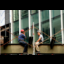

In [15]:
# Probamos una imagen, para verificar la correcta manipulacion de datos
import tensorflow as tf
tf.keras.preprocessing.image.array_to_img(y_test[40])

**Modelo**

Primero definimos una funcion auxiliar

In [0]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Definicion del encoder

In [17]:
# Encoder
# Nota: el input es consistente con el tamanio de Glove50
# Modificar en caso de que probemos un encaje mas grande

original_inputs = Input(shape=(50,), name='encoder_input')
x = Dense(100, activation='relu')(original_inputs)
#x = Conv2D(64, kernel_size=4,strides=2,padding= 'same',activation='relu')(x)
z_mean = Dense(150, name='z_mean')(x)
z_log_var = Dense(150, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = Model(inputs=original_inputs, outputs=z, name='encoder')

# Final encoder
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          5100        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 150)          15150       dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 150)          15150       dense[0][0]                      
____________________________________________________________________________________________

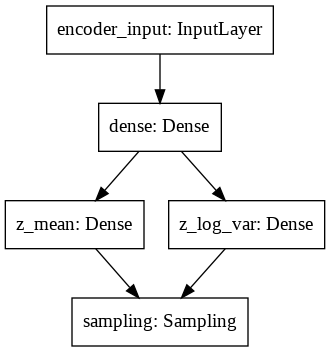

In [18]:
plot_model(encoder,show_layer_names=True)

Definicion del decoder

In [19]:
# Decoder

latent_inputs = Input(shape=(150,), name='z_sampling')
x = Dense(300, activation='relu')(latent_inputs)
x = Dense(600, activation='sigmoid')(x)
x = Dense(12288, activation='sigmoid')(x)
outputs = reshape(x, shape=(1, 64, 64, 3))
decoder = Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Final encoder
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 150)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               45300     
_________________________________________________________________
dense_2 (Dense)              (None, 600)               180600    
_________________________________________________________________
dense_3 (Dense)              (None, 12288)             7385088   
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(1, 64, 64, 3)]          0         
Total params: 7,610,988
Trainable params: 7,610,988
Non-trainable params: 0
_________________________________________________________________


In [0]:
#plot_model(decoder,show_layer_names=True)

In [21]:
# Modelo VAE
outputs = decoder(z)
vae = Model(inputs=original_inputs, outputs=outputs, name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          5100        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 150)          15150       dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 150)          15150       dense[0][0]                      
________________________________________________________________________________________________

In [0]:
#plot_model(vae, show_layer_names=True)

In [0]:
# Agregamos la divergencia Kullback Liber para regularizacion de funcion de perdida
kl_loss = - 0.5 * tf.reduce_mean(
    z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

In [0]:
import os
checkpoint_path = "/content/drive/My Drive/Proyecto_Deep/pesos/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [25]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period = 5
                                                 )

Entrenamos

In [26]:
# Train.
optimizer = RMSprop(learning_rate=1e-2) #Adam(learning_rate=1e-4) #SGD(learning_rate=1e-4) # 
vae.compile(optimizer, loss = MeanSquaredError(), metrics=['accuracy'])
hist=vae.fit(x_train,y_train, epochs=10,callbacks=[cp_callback], batch_size=1, shuffle=True, validation_data=(x_test,y_test) )

Epoch 1/10
32364/32364 [==============================] - 283s 9ms/step - loss: 0.0704 - accuracy: 0.4415 - val_loss: 0.0686 - val_accuracy: 0.3970
Epoch 2/10
32364/32364 [==============================] - 283s 9ms/step - loss: 0.0694 - accuracy: 0.4402 - val_loss: 0.0689 - val_accuracy: 0.4633
Epoch 3/10
32364/32364 [==============================] - 283s 9ms/step - loss: 0.0694 - accuracy: 0.4427 - val_loss: 0.0689 - val_accuracy: 0.4363
Epoch 4/10
32364/32364 [==============================] - 284s 9ms/step - loss: 0.0695 - accuracy: 0.4420 - val_loss: 0.0699 - val_accuracy: 0.3843
Epoch 5/10
32361/32364 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.4426
Epoch 00005: saving model to /content/drive/My Drive/Proyecto_Deep/pesos/cp-0005.ckpt
32364/32364 [==============================] - 286s 9ms/step - loss: 0.0694 - accuracy: 0.4426 - val_loss: 0.0683 - val_accuracy: 0.3137
Epoch 6/10
32364/32364 [==============================] - 284s 9ms/step - loss: 0.069

In [43]:
ls {checkpoint_dir}

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/Proyecto_Deep/pickles': No such file or directory


In [0]:
#plot_model(vae, show_layer_names=True)

In [0]:
def viendo_imagenes(i):

  pruebita= encoder.predict(np.array([x_train[i]]))
  pruebita2= decoder.predict(pruebita)

  return tf.keras.preprocessing.image.array_to_img(pruebita2.reshape(64,64,3) )

In [0]:
path_glove = '/content/drive/My Drive/Proyecto_Deep/pickles/glove.6B.50d.txt)

In [0]:
def load_glove(path_to_glove='/content/drive/My Drive/Proyecto_Deep/pickles/glove.6B.50d.txt'):
    '''
    Obtenemos la representacion de la coleccion glove.GB.XXd.txt especificada
    '''

    # Lectura del archivo donde se tiene la representacion de glove
    file = open(path_to_glove, mode='rt', encoding='utf8')

    # Obtenemos un array con la representacion numerica de las palabras
    word2em = {}
    for line in file:
        words = line.strip().split()
        word = words[0]
        embeds = np.array(words[1:], dtype=np.float32)
        word2em[word] = embeds

    file.close()

    return word2em

In [0]:
word2em = load_glove()

In [0]:
import numpy as np

def encode_doc(doc, embedding_dim=50, max_allowed_doc_length=None):
    '''
    Representacion de una oracion en la coleccion glove.GB.XXd.txt antes cargada
    Nota: se fija un parametro de longitud maxima
    '''

    words = [w.lower() for w in doc.split(' ')]
    max_len = len(words)
    if max_allowed_doc_length is not None:
        max_len = min(len(words), max_allowed_doc_length)
        E = np.zeros(shape=(embedding_dim, max_len))
        X = np.zeros(shape=(embedding_dim, ))
        for j in range(max_len):
            word = words[j]
            try:
                E[:, j] = word2em[word]
            except KeyError:
                pass
        X[:] = np.sum(E, axis=1)
    return X

In [33]:
prueba = "a child in a green jacket is running across the street"
prueba

'a child in a green jacket is running across the street'

In [47]:
pruebaEmb=encode_doc(prueba,50,100)
pruebaEmb.shape

(50,)

In [46]:
x_train[90].shape

(50,)

In [48]:
pruebita= encoder.predict(np.array([x_train[90]]))
pruebita2= decoder.predict(pruebita)
type(pruebita)

numpy.ndarray

In [53]:
pruebita= encoder.predict(np.array([pruebaEmb]))
pruebita2= decoder.predict(pruebita)
result =tf.keras.preprocessing.image.array_to_img(pruebita2.reshape(64,64,3) )
type(result)

PIL.Image.Image

In [0]:
im1 = result.save("texto_creado.png") 

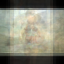

In [36]:
viendo_imagenes(90)

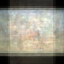

In [0]:
viendo_imagenes(1200)

In [0]:
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


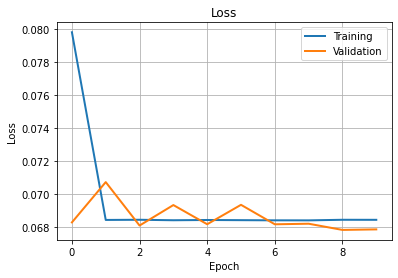

In [0]:
# Plot loss
plt.title('Loss')
plt.plot(hist.history['loss'], label='Training', linewidth=2)
plt.plot(hist.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

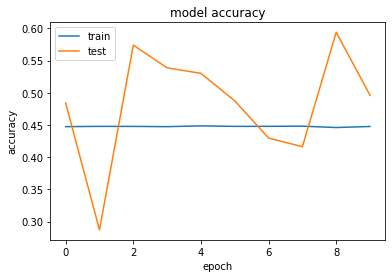

In [0]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Saving
decoder.save('decorder.h5')
encoder.save('encorder.h5')
vae.save('vae.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
del decoder
del encoder 
del vae